In [21]:
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
import numpy as np

In [22]:
matches = sb.matches(competition_id=43, season_id=106)

In [23]:
sb.matches(competition_id=43, season_id=106).match_id

0     3857256
1     3869151
2     3857257
3     3857258
4     3857288
       ...   
59    3857265
60    3857262
61    3857261
62    3857255
63    3857254
Name: match_id, Length: 64, dtype: int64

In [24]:
match_ids = matches['match_id'].tolist()

In [26]:
import pandas as pd
import numpy as np

def fetch_and_filter_goals(match_id):
    # Assuming sb.events() fetches match events from StatsBomb or similar source
    events = sb.events(match_id=match_id)
    
    # Filter for 'Shot' events that resulted in a 'Goal'
    goals = events[(events['type'] == 'Shot') & (events['shot_outcome'] == 'Goal')]
    
    # Select relevant columns for analysis
    goals = goals[['id', 'minute', 'second', 'team', 'player']]
    
    return goals

def categorize_goals_by_match_phase(goals):
    # Add a new column for match phase based on the minute the goal was scored
    conditions = [
        (goals['minute'] <= 15),  # Early game
        (goals['minute'] <= 45),  # Mid-game (first half)
        (goals['minute'] <= 75),  # Mid-game (second half)
        (goals['minute'] > 75)    # Late game + added time
    ]
    choices = ['Early Game', 'Mid-Game First Half', 'Mid-Game Second Half', 'Late Game']
    goals['Match Phase'] = np.select(conditions, choices, default='Unknown')
    
    return goals

# Initialize an empty DataFrame to store all goals from all matches
all_goals = pd.DataFrame()

for match_id in match_ids:
    try:
        # Fetch and filter goals for the match
        match_goals = fetch_and_filter_goals(match_id)
        
        # Categorize these goals by match phase
        match_goals_with_phase = categorize_goals_by_match_phase(match_goals)
        
        # Concatenate the goals from this match with the cumulative DataFrame
        all_goals = pd.concat([all_goals, match_goals_with_phase], ignore_index=True)
    except Exception as e:
        print(f"Failed to process match {match_id}: {e}")

# Now, aggregate goals by team and phase for analysis
goal_distribution_by_team = all_goals.groupby(['team', 'Match Phase']).size().reset_index(name='Goals')

# Optionally, export this aggregated data for further analysis or visualization
goal_distribution_by_team.to_csv('goal_distribution_by_team_and_phase.csv', index=False)

In [3]:
# Load the two CSV files
goal_data = pd.read_csv('goal_distribution_by_team_and_phase.csv')
continent_data = pd.read_csv('Countries by continents.csv')

# Display the first few rows of each dataframe
goal_data.head(), continent_data.head()

# Merge the datasets on the team and Country columns
merged_data = pd.merge(goal_data, continent_data, left_on='team', right_on='Country', how='left')

# Group by team, Country, Continent, and Match Phase, and sum the goals
goal_continent_phase_summary = merged_data.groupby(['team', 'Country', 'Continent', 'Match Phase']).agg({'Goals': 'sum'}).reset_index()

goal_continent_phase_summary.head()

# Save the resulting dataframe to a new CSV file
goal_continent_phase_summary.to_csv('goal_distribution_by_team_and_phase_continent.csv', index=False)


ignore below

In [27]:

def fetch_and_filter_goals2(match_id):
    # Assuming sb.events() fetches match events from StatsBomb or similar source
    events = sb.events(match_id=match_id)
    
    # Filter for 'Shot' events that resulted in a 'Goal'
    goals = events[(events['type'] == 'Shot') & (events['shot_outcome'] == 'Goal')]
    
    # Select relevant columns for analysis, and add 'match_id' for tracking
    goals = goals[['id', 'minute', 'second', 'team', 'player']]
    goals['match_id'] = match_id  # Add match_id to each goal
    
    return goals


# Initialize an empty DataFrame to store detailed goal information from all matches
detailed_goals = pd.DataFrame()

for match_id in match_ids:
    try:
        # Fetch and filter goals for the match, including match ID
        match_goals = fetch_and_filter_goals2(match_id)
        
        # Concatenate the goals from this match with the cumulative DataFrame
        detailed_goals = pd.concat([detailed_goals, match_goals], ignore_index=True)
    except Exception as e:
        print(f"Failed to process match {match_id}: {e}")

# Export this detailed data to CSV for further analysis or visualization
detailed_goals.to_csv('detailed_goal_distribution.csv', index=False)

In [30]:
# Load both CSV files into pandas DataFrames
goal_distribution_file_path = 'detailed_goal_distribution.csv'
players_file_path = 'players_22.csv'
goal_distribution_data = pd.read_csv(goal_distribution_file_path)
players_data = pd.read_csv(players_file_path)

# Define a function to categorize player positions
def categorize_position(positions):
    pos_list = positions.split(", ")
    for pos in pos_list:
        if pos in ['ST', 'LW', 'RW']:
            return 'Forward'
        elif pos in ['LM', 'RM', 'CM', 'CAM', 'CDM']:
            return 'Midfielder'
        elif pos in ['CB', 'RB', 'LB']:
            return 'Defender'
        elif pos == 'GK':
            return 'Goalkeeper'
    return 'Unknown'

# Apply the categorization function to the player_positions column
players_data['player_position_category'] = players_data['player_positions'].apply(categorize_position)

# Merge the goal distribution data with the player data using players' long names
merged_data_long_name = pd.merge(goal_distribution_data, players_data[['long_name', 'player_position_category']],
                                 left_on='player', right_on='long_name', how='inner')

# Drop any rows with missing values from the merged DataFrame
cleaned_data_long_name = merged_data_long_name.dropna()

# Select only the relevant columns: match_id and player_position_category
final_data_long_name = cleaned_data_long_name[['match_id', 'player_position_category']]

# Display the first few rows of the final DataFrame
print(final_data_long_name.head())
final_data_long_name.to_csv('final_data_long_name.csv', index=False)



   match_id player_position_category
0   3857256                  Forward
1   3857256                  Forward
2   3857256                  Forward
3   3857256                  Forward
4   3869151                  Forward


In [32]:
# Identify the unique match_ids and sort them
unique_match_ids = final_data_long_name['match_id'].drop_duplicates().sort_values()

# Assign "stage" based on the order and count of match_ids
match_id_to_stage = {}
count = 0
for match_id in unique_match_ids:
    if count < 48:
        match_id_to_stage[match_id] = 'GROUP'
    elif count < 48 + 8:
        match_id_to_stage[match_id] = 'R16'
    elif count < 48 + 8 + 4:
        match_id_to_stage[match_id] = 'QTR'
    elif count < 48 + 8 + 4 + 2:
        match_id_to_stage[match_id] = 'SEMI'
    else:
        match_id_to_stage[match_id] = 'FINAL'
    count += 1

# Replace match_id in the dataset with the corresponding stage
final_data_with_stage = final_data_long_name.copy()
final_data_with_stage['stage'] = final_data_with_stage['match_id'].map(match_id_to_stage)
final_data_with_stage.drop('match_id', axis=1, inplace=True)

# Save the modified dataset to a new CSV file
output_file_path = 'modified_goal_distribution_with_stage.csv'
final_data_with_stage.to_csv(output_file_path, index=False)



In [37]:
goals_data1 = 'modified_goal_distribution_with_stage.csv'
goals_data = pd.read_csv(goals_data1)

# Define stage order
stage_order = ['GROUP', 'R16', 'QTR', 'SEMI', 'FINAL']

# Aggregate goals by player position and stage
goal_counts = goals_data.groupby(['player_position_category', 'stage']).size().reset_index(name='goals')

# Ensure the stages are in the correct order for visualization
goal_counts['stage'] = pd.Categorical(goal_counts['stage'], categories=stage_order, ordered=True)
goal_counts = goal_counts.sort_values(by='stage')

# Pivot the data to have stages as rows and positions as columns, filling missing values with 0
goal_counts_pivot = goal_counts.pivot(index='stage', columns='player_position_category', values='goals').fillna(0)

# Calculate cumulative goals
cumulative_goals = goal_counts_pivot.cumsum()

cumulative_goals

player_position_category,Defender,Forward,Midfielder
stage,,,
GROUP,9,79,40
R16,12,89,43


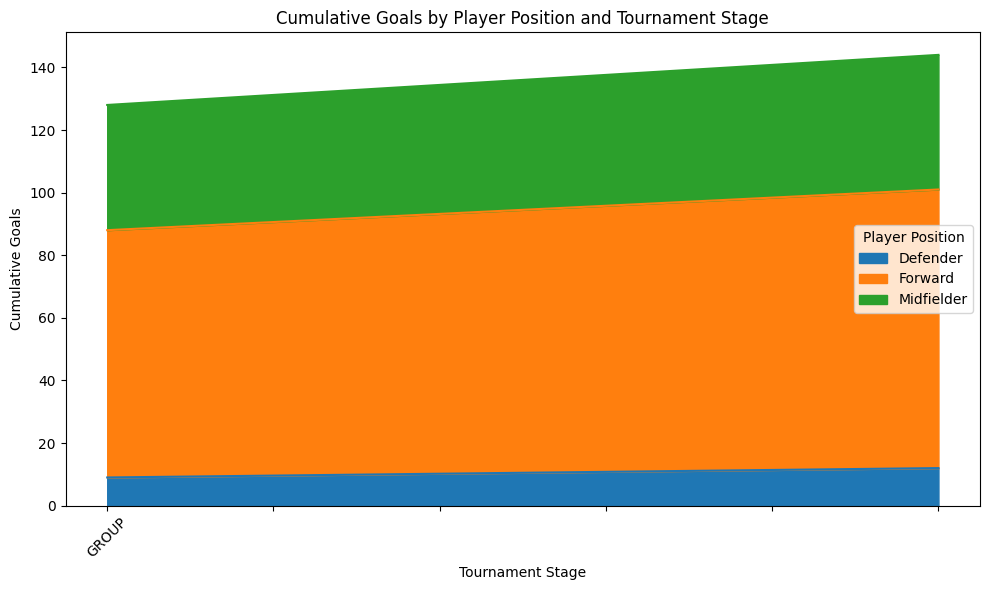

In [38]:
import matplotlib.pyplot as plt

# Plot the cumulative goals as a stacked area chart
cumulative_goals.plot(kind='area', stacked=True, figsize=(10, 6))
plt.title('Cumulative Goals by Player Position and Tournament Stage')
plt.xlabel('Tournament Stage')
plt.ylabel('Cumulative Goals')
plt.xticks(rotation=45)
plt.legend(title='Player Position')
plt.tight_layout()

In [39]:
file_path = 'final_data_long_name.csv'
goals_data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
print(goals_data.head())

   match_id player_position_category
0   3857256                  Forward
1   3857256                  Forward
2   3857256                  Forward
3   3857256                  Forward
4   3869151                  Forward


In [40]:
# Sort data by 'match_id' to maintain chronological order
goals_data_sorted = goals_data.sort_values(by='match_id')

# Aggregate goals by player position and match, then calculate cumulative goals
cumulative_goals = goals_data_sorted.groupby(['match_id', 'player_position_category']).size().groupby(level=1).cumsum().reset_index(name='cumulative_goals')

# Pivot data for plotting
cumulative_goals_pivot = cumulative_goals.pivot(index='match_id', columns='player_position_category', values='cumulative_goals')

# Fill missing values with the previous values (forward fill) to handle matches where some positions may not score
cumulative_goals_pivot_filled = cumulative_goals_pivot.fillna(method='ffill')

print(cumulative_goals_pivot_filled.head())

player_position_category  Defender  Forward  Midfielder
match_id                                               
3857255                        NaN      1.0         NaN
3857256                        NaN      5.0         NaN
3857258                        NaN      7.0         NaN
3857259                        2.0     10.0         1.0
3857260                        2.0     11.0         2.0


C:\Users\xande\AppData\Local\Temp\ipykernel_18444\2147514174.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cumulative_goals_pivot_filled = cumulative_goals_pivot.fillna(method='ffill')


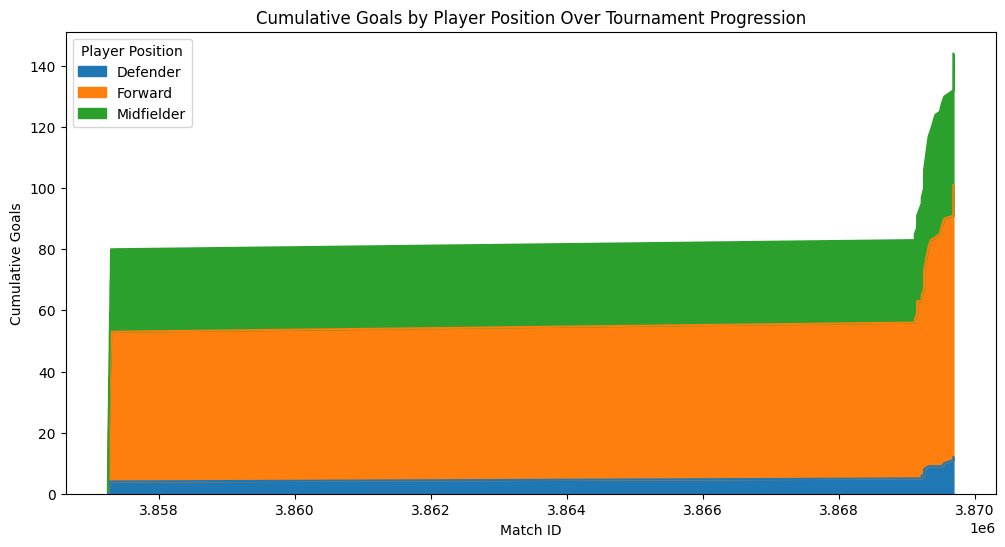

In [41]:
import matplotlib.pyplot as plt

# Plot
cumulative_goals_pivot_filled.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Cumulative Goals by Player Position Over Tournament Progression')
plt.xlabel('Match ID')
plt.ylabel('Cumulative Goals')
plt.legend(title='Player Position')
plt.show()

In [42]:
import pandas as pd

goals_data1 = 'modified_goal_distribution_with_stage.csv'
goals_data = pd.read_csv(goals_data1)

# Define stage order
stage_order = ['GROUP', 'R16', 'QTR', 'SEMI', 'FINAL']

# Aggregate goals by player position and stage
goal_counts = goals_data.groupby(['player_position_category', 'stage']).size().reset_index(name='goals')

# Ensure the stages are in the correct order for visualization
goal_counts['stage'] = pd.Categorical(goal_counts['stage'], categories=stage_order, ordered=True)
goal_counts = goal_counts.sort_values(by='stage')

# Pivot the data to have stages as rows and positions as columns, filling missing values with 0
goal_counts_pivot = goal_counts.pivot(index='stage', columns='player_position_category', values='goals').fillna(0)

goal_counts_pivot

player_position_category,Defender,Forward,Midfielder
stage,,,
GROUP,9,79,40
R16,3,10,3


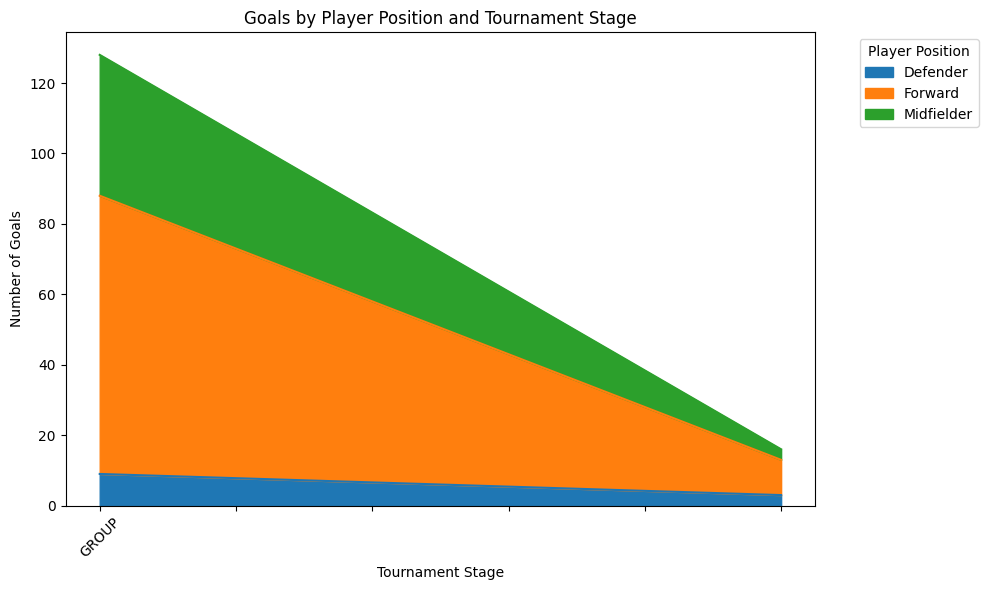

In [43]:
import matplotlib.pyplot as plt

# Assuming 'goal_counts_pivot' is already prepared as shown previously
goal_counts_pivot.plot(kind='area', stacked=True, figsize=(10, 6))

plt.title('Goals by Player Position and Tournament Stage')
plt.xlabel('Tournament Stage')
plt.ylabel('Number of Goals')
plt.xticks(rotation=45)
plt.legend(title='Player Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()